# 주성분분석

In [1]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
SP500_DATA_CSV = './datasets/sp500_data.csv.gz'
SP500_SECTORS_CSV = './datasets/sp500_sectors.csv'
LOAN_DATA_CSV = './datasets/loan_data.csv.gz'
HOUSE_TASKS_CSV = './datasets/housetasks.csv'

In [3]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
oil_px = sp500_px[['XOM', 'CVX']]
oil_px.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5647 entries, 1993-01-29 to 2015-07-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XOM     5647 non-null   float64
 1   CVX     5647 non-null   float64
dtypes: float64(2)
memory usage: 132.4+ KB


In [4]:
pca = PCA(n_components=2)
pca.fit(oil_px)
loadings = pd.DataFrame(pca.components_, columns=oil_px.columns)
loadings

,XOM,CVX
0,-0.664711,-0.747101
1,0.747101,-0.664711


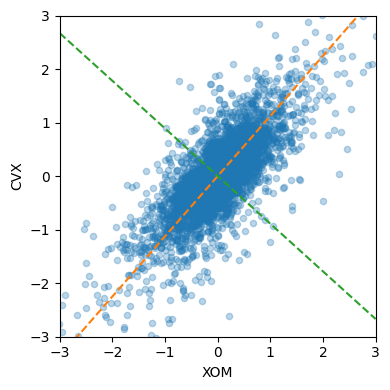

In [5]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
        '--', color='C2')

plt.tight_layout()
plt.show()

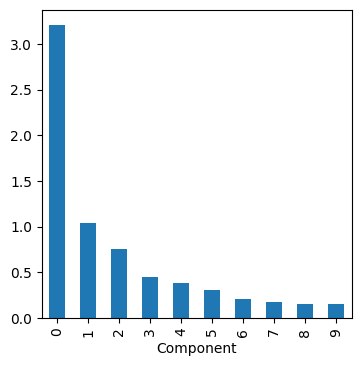

In [6]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

loadings = pd.DataFrame(sp_pca.components_, columns=top_sp.columns)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4,4))
ax.set_xlabel('Component')
plt.show()

In [7]:
loadings

,AAPL,AXP,COP,COST,CSCO,CVX,HD,INTC,JPM,MSFT,SLB,TGT,USB,WFC,WMT,XOM
0,-0.300825,-0.246332,-0.261529,-0.273634,-0.064059,-0.444490,-0.207983,-0.076956,-0.196397,-0.105012,-0.481786,-0.148833,-0.116421,-0.145684,-0.122304,-0.317952
1,-0.505116,-0.139426,0.174212,-0.416307,-0.031939,0.289373,-0.278002,-0.033898,-0.040723,-0.053954,0.472494,-0.228123,-0.054796,-0.047427,-0.222889,0.154192
2,-0.786730,0.135458,-0.002367,0.465862,-0.007524,0.082374,0.166320,-0.003518,0.062261,0.016248,-0.194822,0.160833,0.048976,0.041932,0.175806,0.090167
3,-0.120586,0.061814,-0.206026,0.092596,0.003904,-0.577665,0.162814,-0.001605,0.057687,-0.012558,0.680914,0.109895,0.016752,0.018614,0.058439,-0.295204
4,0.111576,-0.596666,-0.005813,0.555529,-0.039860,0.109016,-0.185488,-0.072047,-0.385160,-0.077135,0.181332,-0.055557,-0.155440,-0.216425,0.091541,0.013277
5,0.051190,0.360828,-0.053082,0.342257,0.015821,-0.080419,-0.795487,0.009757,0.215283,0.024611,0.012419,-0.167647,0.091667,0.101324,-0.085415,-0.080227
6,-0.016045,-0.173186,-0.166744,-0.271354,0.024836,0.139474,-0.368063,-0.003623,0.076472,0.026729,0.026587,0.730566,0.000991,0.019284,0.411631,-0.044172
7,0.006115,0.493568,0.359163,0.001817,-0.051571,0.086653,-0.027661,-0.060389,-0.538859,-0.115315,0.023007,0.289250,-0.190460,-0.257295,-0.126670,-0.326172
8,-0.000591,-0.117768,0.499028,0.018472,0.008219,-0.548657,-0.119139,0.035807,0.001504,0.017838,-0.068504,0.279108,-0.036404,0.011910,-0.190159,0.547402
9,-0.018211,-0.336789,0.368282,0.121362,-0.002379,0.126468,0.051657,0.010869,0.392391,0.003267,-0.055342,0.218924,0.101994,0.145371,-0.432888,-0.541475


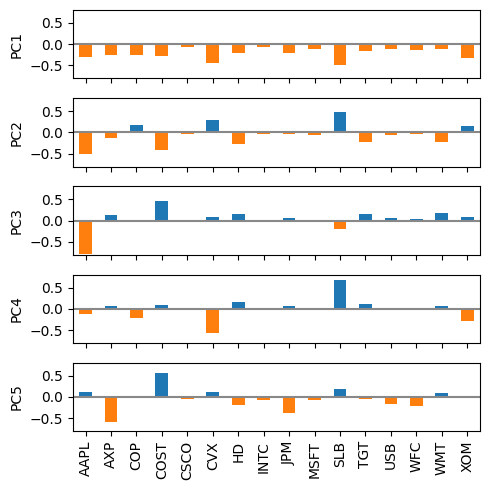

In [8]:
maxPC = 1.01 * loadings.loc[0:5, :].abs().to_numpy().max()

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

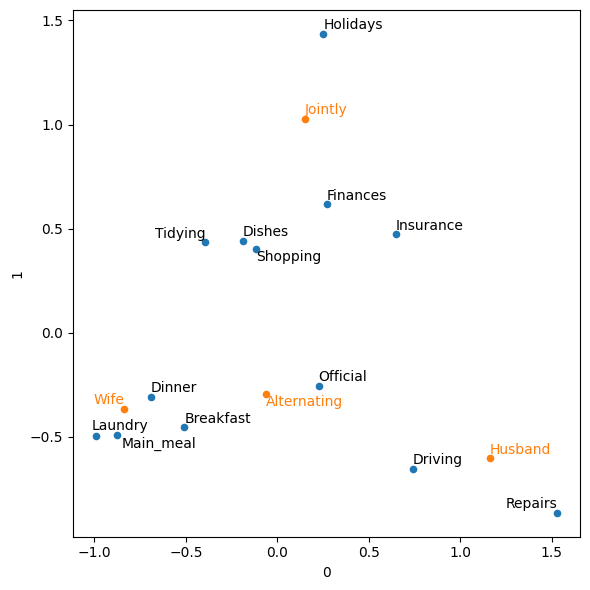

In [9]:
from adjustText import adjust_text

housetasks = pd.read_csv(HOUSE_TASKS_CSV, index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ax = ca.row_coordinates(housetasks).plot.scatter(x=0, y=1, figsize=(6,6))
ca.column_coordinates(housetasks).plot.scatter(x=0, y=1, ax=ax, c='C1')
texts = []
for idx, row in ca.row_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx))
for idx, row in ca.column_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx, color='C1'))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}) 
plt.tight_layout()
plt.show()

# k-평균 클러스터링

In [10]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
df

,XOM,CVX
2011-01-03,0.736805,0.240681
2011-01-04,0.168668,-0.584516
2011-01-05,0.026631,0.446985
2011-01-06,0.248558,-0.919751
2011-01-07,0.337329,0.180511
...,...,...
2015-06-25,-0.919998,-1.110001
2015-06-26,0.029999,0.360000
2015-06-29,-0.230003,-0.809998
2015-06-30,-0.540001,-0.979996


In [11]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df)

/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [12]:
df['cluster'] = kmeans.labels_
df

,XOM,CVX,cluster
2011-01-03,0.736805,0.240681,2
2011-01-04,0.168668,-0.584516,1
2011-01-05,0.026631,0.446985,2
2011-01-06,0.248558,-0.919751,1
2011-01-07,0.337329,0.180511,2
...,...,...,...
2015-06-25,-0.919998,-1.110001,3
2015-06-26,0.029999,0.360000,2
2015-06-29,-0.230003,-0.809998,1
2015-06-30,-0.540001,-0.979996,1


In [13]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
centers

,XOM,CVX
0,0.960948,1.376572
1,-0.328486,-0.566914
2,0.242519,0.336479
3,-1.143980,-1.750297


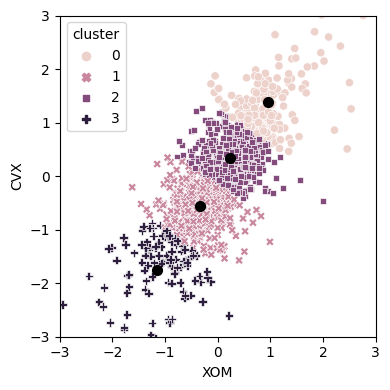

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(data=df, x='XOM', y='CVX', hue='cluster',
                    style='cluster', ax=ax)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

plt.tight_layout()
plt.show()

In [15]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5).fit(top_sp)

/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
from collections import Counter

Counter(kmeans.labels_)

Counter({4: 303, 1: 264, 2: 297, 0: 160, 3: 107})

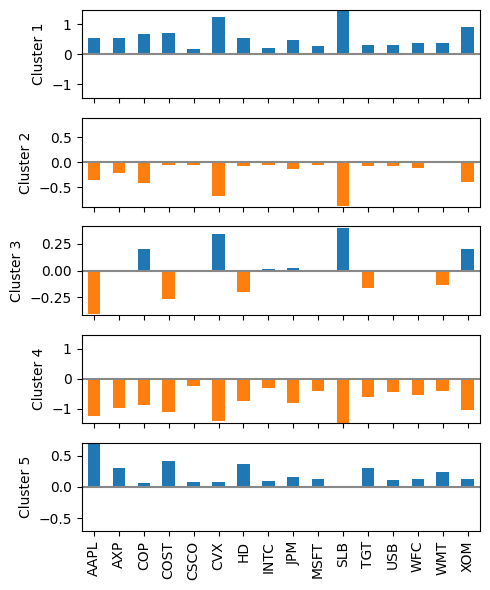

In [17]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

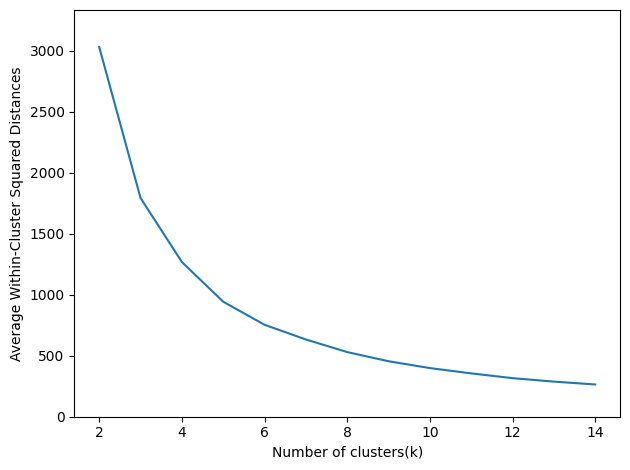

In [18]:
inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

# 계층적 클러스터링

In [19]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()
display(df)
Z = linkage(df, method='complete')

,2011-01-03,2011-01-04,2011-01-05,2011-01-06,2011-01-07,2011-01-10,2011-01-11,2011-01-12,2011-01-13,2011-01-14,...,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01
AAPL,0.527368,-0.154321,0.597152,-0.132850,0.285820,0.485766,-0.434780,0.157012,0.069781,0.347552,...,0.649994,-1.110001,0.120003,-0.450004,0.900002,-1.360001,-0.919998,-0.930000,-0.140000,-0.300004
AMZN,2.850006,-1.139999,3.319992,-0.639999,-2.390000,-0.360000,-1.080002,-1.279999,1.929993,3.250000,...,9.090027,-5.339997,-0.709991,10.399994,-4.130005,2.029999,-3.660004,-5.120026,-0.110016,-1.959991
AXP,0.093870,-0.431788,0.895406,-0.612646,-0.537242,0.245056,0.056553,-0.414713,0.235633,1.244141,...,0.528023,-0.328765,0.567875,-0.079703,-0.199258,-1.105863,-0.288920,-1.414705,-0.449997,-0.239997
COP,-0.336272,-0.463161,-0.057104,-0.463161,-0.006350,0.095172,0.380682,0.038061,-0.704260,0.279170,...,-0.220002,-0.200001,0.100002,0.489998,-0.299999,-0.949997,0.029998,-0.410000,-0.119999,-1.479999
COST,-0.240605,-0.171859,-0.859307,0.249200,-0.257788,0.171865,0.446837,0.249200,0.240604,0.996799,...,1.009995,-0.289993,-0.649994,-0.790008,-1.000000,-1.000000,0.119996,-1.319993,-1.320007,0.700012
CSCO,0.035704,0.008926,0.169599,0.035706,0.098187,-0.133894,-0.017853,0.107116,-0.089263,0.071410,...,0.357246,-0.208393,-0.158775,-0.208393,-0.277860,-0.158775,-0.208393,-0.446558,-0.367171,-0.070000
CVX,0.240681,-0.584516,0.446985,-0.919751,0.180511,-0.464168,0.825197,0.077359,0.146127,0.610301,...,-0.010002,-0.250000,0.459999,0.129997,-0.710006,-1.110001,0.360000,-0.809998,-0.979996,-0.210007
GOOGL,3.938934,-1.751740,4.504517,1.411408,0.265259,-0.295288,-0.850830,-1.241242,-0.140137,3.393402,...,8.179993,1.000000,0.270020,3.600037,-3.909973,-2.349976,-6.650024,-5.500000,-5.050049,-0.359985
HD,0.099184,-0.541005,-0.054099,-0.189354,-0.036064,0.207384,0.225418,0.027053,0.414769,0.703303,...,0.790000,0.790001,0.140000,-0.059998,-0.590004,-1.000000,-0.169999,-1.019997,-0.020005,-0.379997
INTC,-0.137211,0.025726,-0.214392,0.085757,-0.042878,-0.017150,0.188664,0.025726,0.025728,-0.231544,...,0.299999,-0.330002,0.000000,-0.220001,-0.240002,-0.030000,-0.490000,-0.310002,-0.209999,-0.310000


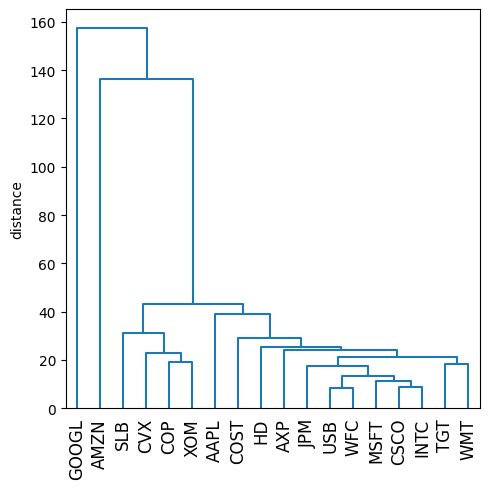

In [20]:
fig, ax = plt.subplots(figsize=(5,5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')
plt.tight_layout()
plt.show()

In [21]:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

1 : COP, CVX, SLB, XOM
2 : AAPL, AXP, COST, CSCO, HD, INTC, JPM, MSFT, TGT, USB, WFC, WMT
3 : AMZN
4 : GOOGL


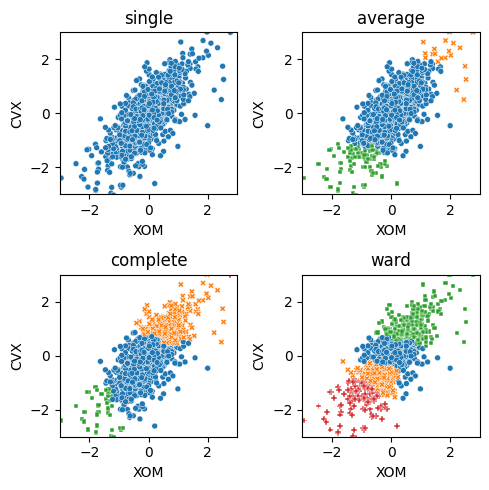

In [22]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                         size=0.5, ax=ax, data=df, legend=False)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(method)

plt.tight_layout()
plt.show()

# 모델 기반 클러스터링

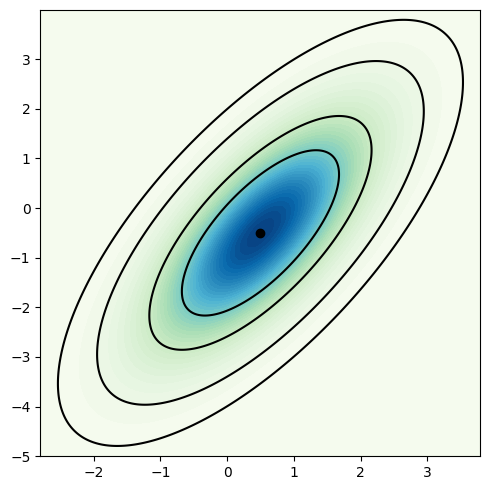

In [23]:
mean = [0.5, -0.5]
cov = [[1, 1], [1, 2]]
probability = [.5, .75, .95, .99]
def probLevel(p):
    D = 1
    return (1 - p) / (2 * math.pi * D)
levels = [probLevel(p) for p in probability]

fig, ax = plt.subplots(figsize=(5, 5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)


CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')


plt.tight_layout()
plt.show()

In [24]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
mclust.bic(df)

4589.3203170532615

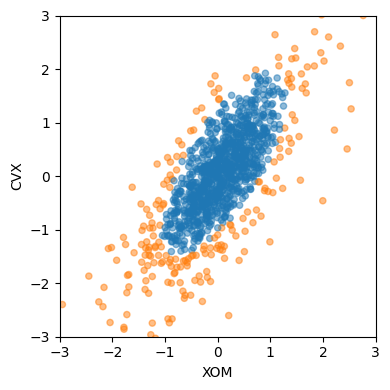

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = [f'C{c}' for c in mclust.predict(df)]
df.plot.scatter(x='XOM', y='CVX', c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

In [26]:
print('Mean')
print(mclust.means_)
print('Covariances')
print(mclust.covariances_)

Mean
[[ 0.0709161   0.10228006]
 [-0.05074943 -0.21539465]]
Covariances
[[[0.27074158 0.27800893]
  [0.27800893 0.5212865 ]]

 [[0.98668327 0.99350046]
  [0.99350046 1.69695919]]]


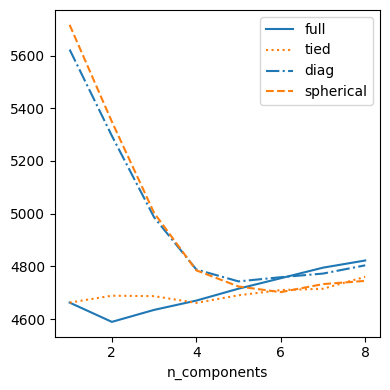

In [27]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components = n_components, warm_start=True,
                                 covariance_type = covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })
        
results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-','C1:','C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, 
                kind='line', style=styles[i]) # , color=colors[i])

plt.tight_layout()
plt.show()

# 스케일링과 범주형 변수

In [29]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)
defaults = loan_data.loc[loan_data['outcome'] == 'default',]

columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 
           'dti', 'revol_util']

df = defaults[columns]
kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
display(centers)

,loan_amnt,annual_inc,revol_bal,open_acc,dti,revol_util,size
0,10274.160906,41241.205530,9950.095008,9.480338,17.718588,57.903425,13023
1,21444.318867,148736.057263,33152.689572,12.376733,13.831145,63.151084,1654
2,24290.909091,409746.465909,84710.988636,13.431818,8.148636,60.015647,88
3,17809.760881,78669.452556,18933.405997,11.594003,17.016428,62.183810,7906


In [31]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 1.0)

kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=columns)
centers['size'] = [counts[i] for i in range(4)]
display(centers)

,loan_amnt,annual_inc,revol_bal,open_acc,dti,revol_util,size
0,10506.814810,51114.024278,11634.707310,7.509576,15.933778,77.784329,7399
1,10323.453512,53466.038196,6052.642631,8.664617,11.309106,30.990055,5357
2,25950.205142,116834.142232,32945.972921,12.396335,16.165914,66.123542,3671
3,13486.397177,55905.907924,16435.679660,14.322746,24.210014,59.462324,6244


,GOOGL,AMZN,AAPL,MSFT,CSCO,INTC,CVX,XOM,SLB,COP,JPM,WFC,USB,AXP,WMT,TGT,HD,COST
2005-01-03,2.657662,-0.430001,-0.099973,-0.047835,-0.089263,-0.423310,-1.103047,-0.728723,-1.110633,-0.696598,-0.248896,-0.120469,-0.110006,-0.513656,-0.320960,-0.724329,0.084594,-0.273346
2005-01-04,-3.453445,-0.529999,0.010060,-0.023919,-0.731955,-0.430737,-0.304046,-0.462308,-0.387634,-0.205508,-0.433680,0.003764,-0.110004,-0.625311,-0.441318,-0.757632,-0.530658,-0.924551
2005-01-05,0.030030,0.200000,0.002677,-0.047835,0.089264,-0.059412,0.148490,-0.266415,0.087109,0.208174,-0.083690,-0.018824,0.080668,-0.455095,-0.168503,-0.124885,-0.261482,0.032159
2005-01-06,-3.268272,-0.760002,-0.008059,-0.079726,0.160673,-0.089119,0.657588,0.642530,0.587981,0.325615,-0.045651,0.056471,-0.029335,-0.134286,0.120357,-1.423682,-0.484512,-0.771800
2005-01-07,1.606598,0.939999,0.285154,-0.119589,-0.178526,0.051985,-0.410107,-0.258578,-0.574915,-0.144125,-0.220642,-0.064000,-0.256675,-0.387940,-0.048141,0.349678,-0.161506,-0.104512


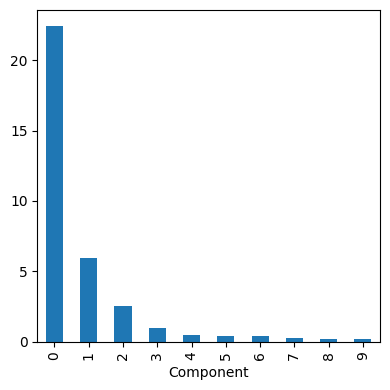

In [32]:
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

display(top_sp1.head())

sp_pca1 = PCA()
sp_pca1.fit(top_sp1)

explained_variance = pd.DataFrame(sp_pca1.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [34]:
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)
display(loadings.transpose())

,0,1
GOOGL,-0.857310,0.477873
AMZN,-0.444728,-0.874149
AAPL,-0.071627,-0.020802
MSFT,-0.036002,-0.006204
CSCO,-0.029205,-0.003045
INTC,-0.026666,-0.006069
CVX,-0.089548,-0.037420
XOM,-0.080336,-0.020511
SLB,-0.110218,-0.030356
COP,-0.057739,-0.024117


In [37]:
# !pip install gower

In [46]:
import gower

x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']]
dist_matrix = gower.gower_matrix(x)

In [48]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps = 0.3, min_samples = 10, metric = "precomputed").fit(dist_matrix)
x['labels'] = db.labels_
x

/tmp/ipykernel_115744/4229640666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['labels'] = db.labels_


,dti,payment_inc_ratio,home_,purpose_,labels
0,1.00,2.39320,RENT,major_purchase,0
1,5.55,4.57170,OWN,small_business,0
2,18.08,9.71600,RENT,other,0
3,10.08,12.21520,RENT,debt_consolidation,0
4,7.06,3.90888,RENT,other,0
...,...,...,...,...,...
22666,17.84,11.55790,RENT,debt_consolidation,0
22667,21.20,7.97040,MORTGAGE,debt_consolidation,0
22668,9.60,12.03640,MORTGAGE,credit_card,0
22669,18.62,13.28970,RENT,other,0


In [51]:
x['labels'].unique()

array([0])

In [67]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']
df = pd.get_dummies(defaults[columns])

scaler = preprocessing.StandardScaler()

df0 = scaler.fit_transform(df * 1.0)
kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df0)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=df.columns)
display(centers)

,dti,payment_inc_ratio,pub_rec_zero,home__MORTGAGE,home__OWN,home__RENT
0,16.977575,9.055062,0.921301,7.049916e-15,-9.575674e-16,1.000000e+00
1,17.197993,9.266666,0.917903,8.326673e-16,1.000000e+00,2.775558e-16
2,21.796605,11.058379,0.975886,1.000000e+00,2.498002e-16,-1.554312e-15
3,13.097357,5.778804,0.838922,1.000000e+00,1.526557e-16,-1.443290e-15


In [68]:
df['label']=kmeans.labels_

In [69]:
dist_matrix = gower.gower_matrix(df0)
kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(dist_matrix)
df['label_gower']=kmeans.labels_

In [70]:
df['label_gower'].value_counts()

0    10137
1     9779
2     1888
3      867
Name: label_gower, dtype: int64